In [1]:
import jax
import jax.numpy as jnp

jax.devices()

[CpuDevice(id=0)]

In [2]:
jnp.ones(10).devices()

{CpuDevice(id=0)}

In [3]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import time
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom
from tqdm import tqdm

import pyfixest as pf
from pyfixest.estimation.demean_ import demean
from pyfixest.estimation.jax.demean_jax_ import demean_jax

In [5]:
# %load_ext watermark
# %watermark --iversions

In [6]:
def generate_test_data(size: int, k: int = 2):
    """
    Generate benchmark data for pyfixest on GPU (similar to the R fixest benchmark data).

    Args:
        size (int): The number of observations in the data frame.
        k (int): The number of covariates in the data frame.

    Returns
    -------
        pd.DataFrame: The generated data frame for the given size.
    """
    # Constants
    all_n = [1000 * 10**i for i in range(5)]
    a = 1
    b = 0.05

    n = all_n[size - 1]

    dum_all = []
    nb_dum = [n // 20, int(np.sqrt(n)), int(n**0.33)]

    dum_all = np.zeros((n, 3))
    dum_all[:, 0] = np.random.choice(nb_dum[0], n, replace=True)
    dum_all[:, 1] = np.random.choice(nb_dum[1], n, replace=True)
    dum_all[:, 2] = np.random.choice(nb_dum[2], n, replace=True)
    dum_all = dum_all.astype(int)

    X1 = np.random.normal(size=n)
    X2 = X1**2

    mu = a * X1 + b * X2

    for m in range(3):
        coef_dum = np.random.normal(size=nb_dum[m])
        mu += coef_dum[dum_all[:, m]]

    mu = np.exp(mu)
    y = nbinom.rvs(0.5, 1 - (mu / (mu + 0.5)), size=n)

    X_full = np.column_stack((X1, X2))
    base = pd.DataFrame(
        {
            "y": y,
            "ln_y": np.log(y + 1),
            "X1": X1,
            "X2": X2,
        }
    )

    if k > 2:
        X = np.random.normal(size=(n, k - 2))
        X_df = pd.DataFrame(X, columns=[f"X{i}" for i in range(3, k + 1, 1)])
        base = pd.concat([base, X_df], axis=1)
        X_full = np.column_stack((X_full, X))

    for m in range(3):
        base[f"dum_{m + 1}"] = dum_all[:, m]

    weights = np.random.uniform(0, 1, n)
    return base, y, X_full, dum_all, weights

In [7]:
df, Y, X, f, weights = generate_test_data(1)

In [8]:
m0 = pf.feols("ln_y ~ X1 | dum_1", df, demeaner_backend="numba")
m0.summary()

###

Estimation:  OLS
Dep. var.: ln_y, Fixed effects: dum_1
Inference:  CRV1
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |      0.436 |        0.046 |     9.440 |      0.000 |  0.343 |   0.529 |
---
RMSE: 1.067 R2: 0.242 R2 Within: 0.131 


In [9]:
m1 = pf.feols("ln_y ~ X1 | dum_1", df, demeaner_backend="jax")
m1.summary()

###

Estimation:  OLS
Dep. var.: ln_y, Fixed effects: dum_1
Inference:  CRV1
Observations:  1000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |      0.436 |        0.046 |     9.440 |      0.000 |  0.343 |   0.529 |
---
RMSE: 1.067 R2: 0.242 R2 Within: 0.131 


## function

In [10]:
def run_standard_benchmark(
    fixed_effect,
    demeaner_backend,
    size=1,
    k=1,
    solver="np.linalg.lstsq",
    skip_demean_benchmark=True,
):
    """
    Run the fixest standard benchmark fixed effect models. This is the function the benchmarks
    will loop over.

    Args:
        fixed_effect (str): The fixed effect to use. Must be a list of variables as "dum_1", "dum_1+dum_2", or "dum_1+dum_2+dum_3", etc.
        demeaner_backend (str): The backend to use for demeaning. Must be "numba" or "jax".
        size (int): The size of the data to generate. Must be between 1 and 5. For 1, N = 1000, for 2, N = 10000, etc.
        k_vals (int): The number of covariates to generate.
        solver (str): The solver to use for the estimation. Must be "np.linalg.lstsq". "jax" currently throws an error.
        skip_demean_benchmark (bool): Whether to skip the "pure" demean benchmark. Default is True. Only the full call
            to feols is benchmarked.

    """
    assert fixed_effect in ["dum_1", "dum_1+dum_2", "dum_1+dum_2+dum_3"]

    # one fixed effect
    res = []

    fml_base = "ln_y ~ X1"
    fml = f"{fml_base} | {fixed_effect}"

    # warmup
    df, y, X, f, weights = generate_test_data(1)
    pf.feols(
        fml,
        data=df,
        demeaner_backend=demeaner_backend,
        store_data=False,
        copy_data=False,
        solver=solver,
    )

    if k > 1:
        xfml = "+".join([f"X{i}" for i in range(2, k + 1, 1)])
        fml = f"{fml_base} + {xfml} | {fixed_effect}"
    else:
        fml = f"{fml_base} + X1 | {fixed_effect}"

    for rep in range(1, 11):
        df, Y, X, f, weights = generate_test_data(size=size, k=k)

        tic1 = time.time()
        pf.feols(
            fml,
            data=df,
            demeaner_backend=demeaner_backend,
            store_data=False,
            copy_data=False,
            solver=solver,
        )
        tic2 = time.time()

        full_feols_timing = tic2 - tic1

        demean_timing = np.nan
        if not skip_demean_benchmark:
            YX = np.column_stack((Y.reshape(-1, 1), X))
            tic3 = time.time()
            if demeaner_backend == "jax":
                _, _ = demean_jax(YX, f, weights, tol=1e-10)
            else:
                _, _ = demean(YX, f, weights, tol=1e-10)
            tic4 = time.time()
            demean_timing = tic4 - tic3

        res.append(
            pd.Series(
                {
                    "method": "feols",
                    "solver": solver,
                    "demeaner_backend": demeaner_backend,
                    "n_obs": df.shape[0],
                    "k": k,
                    "G": len(fixed_effect.split("+")),
                    "rep": rep,
                    "full_feols_timing": full_feols_timing,
                    "demean_timing": demean_timing,
                }
            )
        )

    return pd.concat(res, axis=1).T

In [11]:
# test run numba
run_standard_benchmark(fixed_effect="dum_1", demeaner_backend="numba", size=1, k=1)

,method,solver,demeaner_backend,n_obs,k,G,rep,full_feols_timing,demean_timing
0,feols,np.linalg.lstsq,numba,1000,1,1,1,0.150473,NaN
1,feols,np.linalg.lstsq,numba,1000,1,1,2,0.147583,NaN
2,feols,np.linalg.lstsq,numba,1000,1,1,3,0.186491,NaN
3,feols,np.linalg.lstsq,numba,1000,1,1,4,0.190972,NaN
4,feols,np.linalg.lstsq,numba,1000,1,1,5,0.162773,NaN
5,feols,np.linalg.lstsq,numba,1000,1,1,6,0.171777,NaN
6,feols,np.linalg.lstsq,numba,1000,1,1,7,0.166872,NaN
7,feols,np.linalg.lstsq,numba,1000,1,1,8,0.158694,NaN
8,feols,np.linalg.lstsq,numba,1000,1,1,9,0.185547,NaN
9,feols,np.linalg.lstsq,numba,1000,1,1,10,0.158114,NaN


In [12]:
# test run jax
run_standard_benchmark(fixed_effect="dum_1", demeaner_backend="jax", size=1, k=1)

,method,solver,demeaner_backend,n_obs,k,G,rep,full_feols_timing,demean_timing
0,feols,np.linalg.lstsq,jax,1000,1,1,1,0.122831,NaN
1,feols,np.linalg.lstsq,jax,1000,1,1,2,0.122887,NaN
2,feols,np.linalg.lstsq,jax,1000,1,1,3,0.136041,NaN
3,feols,np.linalg.lstsq,jax,1000,1,1,4,0.139644,NaN
4,feols,np.linalg.lstsq,jax,1000,1,1,5,0.136235,NaN
5,feols,np.linalg.lstsq,jax,1000,1,1,6,0.122477,NaN
6,feols,np.linalg.lstsq,jax,1000,1,1,7,0.123122,NaN
7,feols,np.linalg.lstsq,jax,1000,1,1,8,0.119589,NaN
8,feols,np.linalg.lstsq,jax,1000,1,1,9,0.122247,NaN
9,feols,np.linalg.lstsq,jax,1000,1,1,10,0.118353,NaN


In [13]:
def run_all_benchmarks(size_list, k_list):
    """
    Run all the benchmarks.

    Args:
        size_list (list): The list of sizes to run the benchmarks on. 1-> 1000, 2-> 10000, ..., 5-> 10_000_000
        k_list (list): The list of k values to run the benchmarks on.
    """
    res = pd.DataFrame()

    all_combinations = list(
        product(
            ["numba", "jax"],  # demeaner_backend
            ["dum_1", "dum_1+dum_2", "dum_1+dum_2+dum_3"],  # fixef
            size_list,  # size
            k_list,  # k
            ["np.linalg.lstsq"],  # solver
        )
    )

    with tqdm(total=len(all_combinations), desc="Running Benchmarks") as pbar:
        for demeaner_backend, fixef, size, k, solver in all_combinations:
            res = pd.concat(
                [
                    res,
                    run_standard_benchmark(
                        solver=solver,
                        fixed_effect=fixef,
                        demeaner_backend=demeaner_backend,
                        size=size,
                        k=k,
                    ),
                ],
                axis=0,
            )
            pbar.update(1)  # Update the progress bar after each iteration

    return res

## Run Benchmarks

In [14]:
res_all = run_all_benchmarks(
    size_list=[1, 2, 3, 4, 5],  # for N = 1000, 10_000, 100_000, 1_000_000, 10_000_000
    k_list=[1, 10, 50, 100],  # for k = 1, 10, 50, 100
)

Running Benchmarks: 100%|██████████| 24/24 [00:49<00:00,  2.06s/it]


In [15]:
df = (
    res_all.drop(["rep", "solver"], axis=1)
    .groupby(["method", "demeaner_backend", "k", "G", "n_obs"])
    .mean()
    .reset_index()
)
df

,method,demeaner_backend,k,G,n_obs,full_feols_timing,demean_timing
0,feols,jax,1,1,1000,0.127274,NaN
1,feols,jax,1,1,10000,0.142241,NaN
2,feols,jax,1,2,1000,0.134405,NaN
3,feols,jax,1,2,10000,0.168555,NaN
4,feols,jax,1,3,1000,0.139142,NaN
5,feols,jax,1,3,10000,0.189492,NaN
6,feols,jax,5,1,1000,0.144933,NaN
7,feols,jax,5,1,10000,0.147049,NaN
8,feols,jax,5,2,1000,0.147216,NaN
9,feols,jax,5,2,10000,0.175394,NaN


## Visualize

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

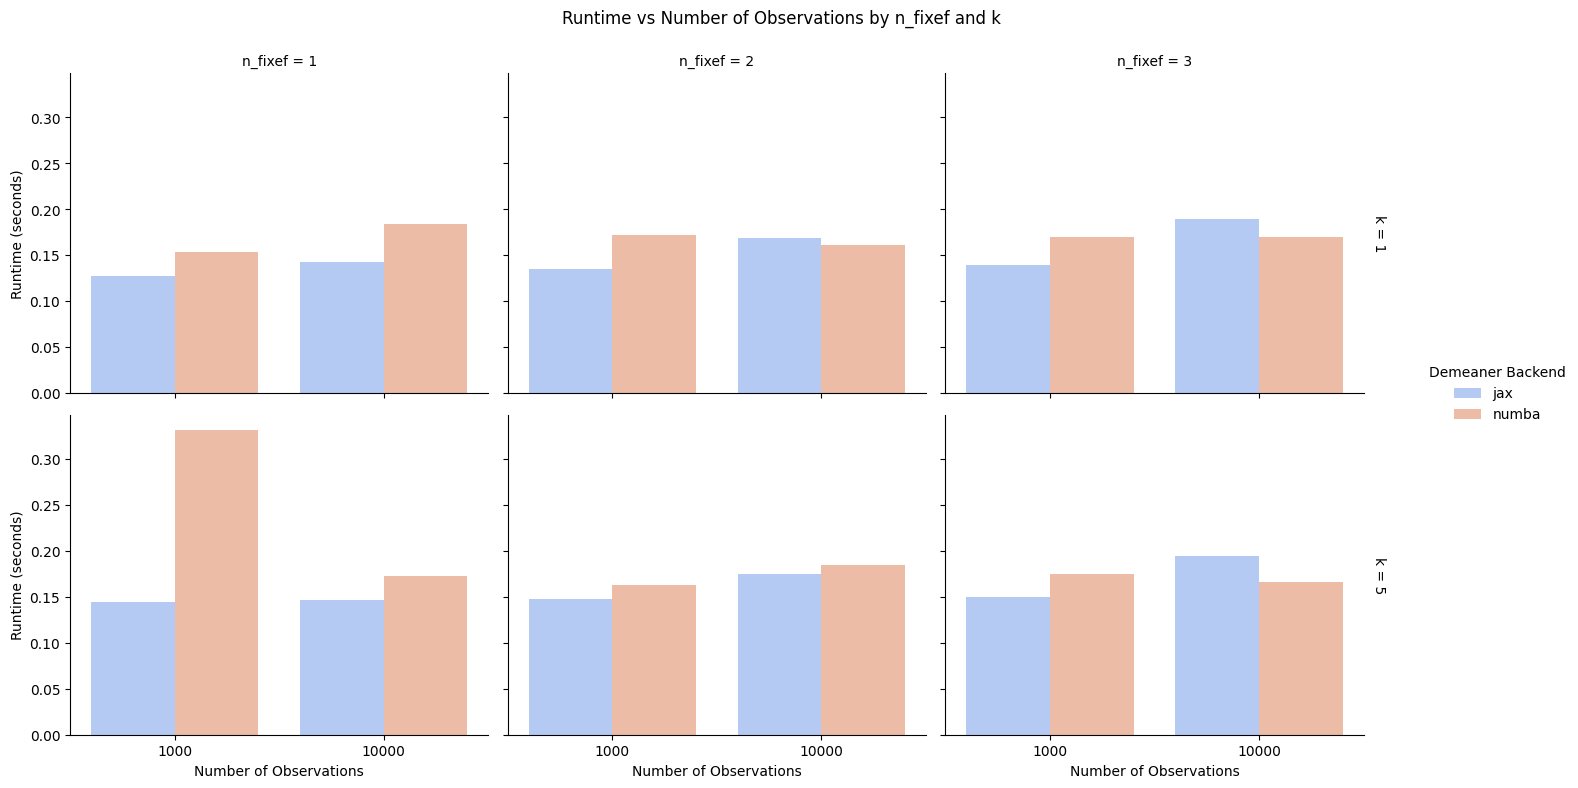

In [16]:
df["G"] = df["G"].map({1: "n_fixef = 1", 2: "n_fixef = 2", 3: "n_fixef = 3"})
df["n_obs"] = df["n_obs"].astype(str)

# Dynamically determine unique values for order and hue_order
n_obs_order = sorted(df["n_obs"].unique(), key=lambda x: int(x))  # Sort as integers
demeaner_backend_order = df["demeaner_backend"].unique()

custom_palette = sns.color_palette("coolwarm", n_colors=2)

# Create the FacetGrid with reordered columns and rows
g = sns.FacetGrid(
    df,
    col="G",  # G (n_fixef) increases left to right
    row="k",  # k increases top to bottom
    margin_titles=True,
    height=4,
    aspect=1.2,
    col_order=["n_fixef = 1", "n_fixef = 2", "n_fixef = 3"],  # Ensure correct order
)

# Plot the bar chart for each facet with the custom palette
g.map(
    sns.barplot,
    "n_obs",
    "full_feols_timing",
    "demeaner_backend",
    order=n_obs_order,  # Dynamic order for n_obs
    hue_order=demeaner_backend_order,  # Dynamic hue order for demeaner_backend
    errorbar=None,  # Suppress error bars
    palette=custom_palette,
)

# Add legend and adjust layout
g.add_legend(title="Demeaner Backend")
g.set_axis_labels("Number of Observations", "Runtime (seconds)")
g.set_titles(row_template="k = {row_name}", col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Runtime vs Number of Observations by n_fixef and k")

# Show plot
plt.show()